In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!curl -L "https://universe.roboflow.com/ds/FdKV8HyZgQ?key=ICm4wUjIoY" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/front_bumber-83-_jpg.rf.92c26cdf664ff0b8e472d87edcb40fd6.jpg  
 extracting: train/front_bumber-9-_jpg.rf.1237bf978f2a2d27bb9b41b2521d3192.jpg  
 extracting: train/front_bumber-9-_jpg.rf.2bb71236dd90b2cfe14987993e8259a5.jpg  
 extracting: train/front_bumber-9-_jpg.rf.49afa11e5886be6f8068627550e5a1a1.jpg  
 extracting: train/front_bumber-9-_jpg.rf.68343ca6f3f668029469ac4bee5356f2.jpg  
 extracting: train/front_bumber-90-_jpg.rf.9c1f5a30421db26e01bc829f4793106f.jpg  
 extracting: train/front_bumber-90-_jpg.rf.a5a2458161fbde7159c2be7e384f1f6f.jpg  
 extracting: train/front_bumber-90-_jpg.rf.a6983eae5c68417e884b0ae312889059.jpg  
 extracting: train/front_bumber-90-_jpg.rf.b60245ad46e3c68c338321eb3bb7258e.jpg  
 extracting: train/front_bumber-93-_jpg.rf.529aeb3183a3d3c80baf4daea29cfab7.jpg  
 extracting: train/front_bumber-93-_jpg.rf.c1b550b0a438a09d69f7e38fa630e739.jpg  
 extracting: train/front_bumber-93-_jpg.rf.ed02f4b3

In [ ]:
import json
import os
import random
import shutil

# Paths to the current dataset
base_dir = "/content/train"  # Replace with the path to your train folder
annotations_file = os.path.join(base_dir, "_annotations.coco.json")

# Define output directories for train and validation sets
output_train_dir = "/content/coco_train/"  # Replace with the desired train folder path
output_val_dir = "/content/coco_val/"      # Replace with the desired validation folder path
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_val_dir, exist_ok=True)

# Load annotations
with open(annotations_file, "r") as f:
    coco_data = json.load(f)

# Get all image IDs
image_ids = [image["id"] for image in coco_data["images"]]
random.shuffle(image_ids)

# Split image IDs for train and validation sets (80/20)
split_index = int(len(image_ids) * 0.8)
train_image_ids = set(image_ids[:split_index])
val_image_ids = set(image_ids[split_index:])

# Create new annotations for train and validation
train_annotations = {"images": [], "annotations": [], "categories": coco_data["categories"]}
val_annotations = {"images": [], "annotations": [], "categories": coco_data["categories"]}

# Distribute images and annotations
image_id_to_file = {image["id"]: image["file_name"] for image in coco_data["images"]}

for image in coco_data["images"]:
    if image["id"] in train_image_ids:
        train_annotations["images"].append(image)
        shutil.copy(
            os.path.join(base_dir, image["file_name"]),
            os.path.join(output_train_dir, image["file_name"])
        )
    elif image["id"] in val_image_ids:
        val_annotations["images"].append(image)
        shutil.copy(
            os.path.join(base_dir, image["file_name"]),
            os.path.join(output_val_dir, image["file_name"])
        )

for annotation in coco_data["annotations"]:
    if annotation["image_id"] in train_image_ids:
        train_annotations["annotations"].append(annotation)
    elif annotation["image_id"] in val_image_ids:
        val_annotations["annotations"].append(annotation)

# Save the new annotation files
with open(os.path.join(output_train_dir, "_annotations.coco.json"), "w") as f:
    json.dump(train_annotations, f)

with open(os.path.join(output_val_dir, "_annotations.coco.json"), "w") as f:
    json.dump(val_annotations, f)

print("Dataset successfully split into train and validation sets!")


Dataset successfully split into train and validation sets!


In [ ]:
import pandas as pd

# Initialize a dictionary to store metrics
metrics = {
    "epoch": [],
    "training_loss": [],
    "validation_loss": [],
    "mAP@0.5:0.95": [],
    "mAP@0.5": [],
    "precision": [],
    "recall": [],
}


In [ ]:
!pip install torch torchvision pycocotools opencv-python

import torchvision

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
###########do changes heree
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import json

# Load COCO annotation file
with open('/content/coco_train/_annotations.coco.json') as f:
    coco_annotations = json.load(f)

# Extract categories
categories = coco_annotations['categories']

# Number of classes including background
num_classes = len(categories) + 1

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [ ]:
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
import os

# Define a custom transform function
def get_transform():
    def transform(image, target):
        # Convert image to tensor
        image = F.to_tensor(image)
        return image, target
    return transform

# Load the dataset
train_dataset = CocoDetection(
    root='/content/coco_train/',
    annFile='/content/coco_train/_annotations.coco.json',
    transforms=get_transform()  # Use the custom transform function
)

# Create the DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=os.cpu_count(),
    collate_fn=lambda x: tuple(zip(*x))
)



loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
for images, targets in train_loader:
    print(type(targets))  # Check if it's a list
    print(type(targets[0]))  # Check the type of the first element in the list
    print(targets[0])  # Inspect the actual structure of the first element
    break


<class 'tuple'>
<class 'list'>
[{'id': 3476, 'image_id': 2272, 'category_id': 3, 'bbox': [310, 64, 281, 395], 'area': 110995, 'segmentation': [], 'iscrowd': 0}, {'id': 3477, 'image_id': 2272, 'category_id': 15, 'bbox': [125, 137, 199, 384], 'area': 76416, 'segmentation': [], 'iscrowd': 0}, {'id': 3478, 'image_id': 2272, 'category_id': 8, 'bbox': [1, 390, 219, 248], 'area': 54312, 'segmentation': [], 'iscrowd': 0}]


In [ ]:
def preprocess_targets(targets):
    processed_targets = []
    for target_list in targets:  # Iterate through the list of targets for each image
        # target_list now contains a list of dictionaries, each representing an object in the image

        # Accumulate boxes, labels, etc. for all objects in the image
        boxes = []
        labels = []
        image_ids = []
        areas = []
        iscrowds = []

        for target in target_list:
            # Convert "bbox" (x, y, w, h) to "boxes" (x_min, y_min, x_max, y_max)
            x, y, w, h = target["bbox"]  # Directly unpack the bbox values
            boxes.append([x, y, x + w, y + h])

            # Collect other target values
            labels.append(target["category_id"])
            image_ids.append(target["image_id"])
            areas.append(target["area"])
            iscrowds.append(target["iscrowd"])

        # Create the processed target dictionary after processing all objects
        processed_target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor(image_ids[0], dtype=torch.int64),  # Use image_id from the first object
            "area": torch.tensor(areas, dtype=torch.float32),
            "iscrowd": torch.tensor(iscrowds, dtype=torch.int64),
        }
        processed_targets.append(processed_target)
    return processed_targets


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, save_path="best_model.pth"):
        """
        Args:
            patience (int): How many epochs to wait for improvement.
            delta (float): Minimum change in validation loss to qualify as improvement.
            save_path (str): Path to save the best model.
        """
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
import os

# Define a custom transform function (reuse from training if same)
def get_transform():
    def transform(image, target):
        # Convert image to tensor
        image = F.to_tensor(image)
        return image, target
    return transform

# Load the validation dataset
val_dataset = CocoDetection(
    root='/content/coco_val/',  # Path to validation images
    annFile='/content/coco_val/_annotations.coco.json',  # Path to validation annotations
    transforms=get_transform()  # Use the same custom transform function
)

# Create the DataLoader
val_loader = DataLoader(
    val_dataset,
    batch_size=16,  # Adjust batch size if needed
    shuffle=False,  # Do not shuffle validation data
    num_workers=os.cpu_count(),  # Use all available CPU cores
    collate_fn=lambda x: tuple(zip(*x))  # Same collate function as training
)




loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
from tqdm import tqdm

def validate(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    results = []
    running_val_loss = 0.0  # Track validation loss

    with torch.no_grad():  # Disable gradient computation
        for images, targets in tqdm(val_loader, desc="Validating"):
            # Move images and targets to GPU
            images = [image.to(device) for image in images]
            targets = preprocess_targets(targets)
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

            # Forward pass
            outputs = model(images)

            # Collect results for evaluation
            for target, output in zip(targets, outputs):
                results.append({
                    "image_id": target["image_id"].item(),
                    "target_boxes": target["boxes"].cpu(),
                    "target_labels": target["labels"].cpu(),
                    "pred_boxes": output["boxes"].cpu(),
                    "pred_scores": output["scores"].cpu(),
                    "pred_labels": output["labels"].cpu(),
                })

            # If you want to calculate validation loss
            model.train()  # Temporarily switch to training mode
            loss_dict = model(images, targets)
            model.eval()  # Switch back to evaluation mode
            running_val_loss += sum(loss for loss in loss_dict.values()).item()

    avg_val_loss = running_val_loss / len(val_loader) if len(val_loader) > 0 else 0
    return results,avg_val_loss


In [ ]:
!pip install pycocotools

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def compute_coco_metrics(results, annotation_file):
    # Load ground truth annotations
    coco_gt = COCO(annotation_file)

    # Prepare predictions in COCO format
    coco_predictions = []
    for result in results:
        for box, score, label in zip(result["pred_boxes"], result["pred_scores"], result["pred_labels"]):
            x_min, y_min, x_max, y_max = box.tolist()
            width = x_max - x_min
            height = y_max - y_min
            coco_predictions.append({
                "image_id": result["image_id"],
                "category_id": label.item(),
                "bbox": [x_min, y_min, width, height],
                "score": score.item(),
            })

    # Load predictions into COCO
    coco_dt = coco_gt.loadRes(coco_predictions)

    # Evaluate predictions
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Extract metrics
    metrics = {
        "mAP@0.5:0.95": coco_eval.stats[0],  # Mean Average Precision @ IoU 0.5:0.95
        "mAP@0.5": coco_eval.stats[1],      # Mean Average Precision @ IoU 0.5
        "Precision": coco_eval.stats[8],    # Precision
        "Recall": coco_eval.stats[9],       # Recall
    }

    return metrics


In [ ]:
#Training the model
import torch.optim as optim

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Path to validation annotations (COCO format)
val_annotation_file = "/content/coco_val/_annotations.coco.json"

# Move the model to the GPU
model.to(device)

# Freeze the backbone
for param in model.backbone.parameters():
    param.requires_grad = False

# Define optimizer
optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),  # Only update trainable parameters
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# Set the model to training mode
model.train()

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.001, save_path="best_model.pth")

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    print(f"Epoch {epoch+1}/{num_epochs} started...")
    running_loss = 0.0  # Accumulate loss over the epoch

    for batch_idx, (images, targets) in enumerate(train_loader):
        # Move images and targets to GPU
        images = [image.to(device) for image in images]  # Ensure images are on the same device as the model
        # Preprocess targets (if required in your preprocess_targets function)
        targets = preprocess_targets(targets)
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]  # Ensure targets are on GPU
        #targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]



        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        # loss_dict = model(images, targets)  # Assuming this line correctly returns a list of loss dictionaries
        # losses = sum(loss for loss in loss_dict.values() if isinstance(loss, torch.Tensor))

        # Backward pass
        optimizer.zero_grad()
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

        # # Accumulate and print loss
        # if (batch_idx + 1) % 10 == 0:  # Print every 10 batches
        #     print(f"Batch [{batch_idx+1}/{len(train_loader)}], Loss: {losses.item():.4f}")

    # Average loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")
    # Validate and compute metrics
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        results, avg_val_loss = validate(model, val_loader, device)
        coco_metrics = compute_coco_metrics(results, val_annotation_file)

    # Update metrics dictionary
    metrics["epoch"].append(epoch + 1)
    metrics["training_loss"].append(avg_train_loss)
    metrics["validation_loss"].append(avg_val_loss)
    metrics["mAP@0.5:0.95"].append(coco_metrics["mAP@0.5:0.95"])
    metrics["mAP@0.5"].append(coco_metrics["mAP@0.5"])
    metrics["precision"].append(coco_metrics["Precision"])
    metrics["recall"].append(coco_metrics["Recall"])

    # Print metrics for the epoch
    print(f"Epoch [{epoch+1}] - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, "
              f"mAP@0.5: {coco_metrics['mAP@0.5']:.4f}")

    # Check early stopping
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print("Training complete!")




Using device: cuda
Epoch 1/50 started...
Epoch [1/50], Training Loss: 0.3925


Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.89s).
Accumulating evaluation results...
DONE (t=1.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.176
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.54s).
Accumulating evaluation results...
DONE (t=1.28s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.64s).
Accumulating evaluation results...
DONE (t=1.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.77s).
Accumulating evaluation results...
DONE (t=1.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.44s).
Accumulating evaluation results...
DONE (t=1.27s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.02s).
Accumulating evaluation results...
DONE (t=1.44s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.251
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.62s).
Accumulating evaluation results...
DONE (t=1.37s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.14s).
Accumulating evaluation results...
DONE (t=1.43s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.68s).
Accumulating evaluation results...
DONE (t=1.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.59s).
Accumulating evaluation results...
DONE (t=1.29s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.99s).
Accumulating evaluation results...
DONE (t=1.43s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.15s).
Accumulating evaluation results...
DONE (t=1.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.22s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.74s).
Accumulating evaluation results...
DONE (t=1.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.56s).
Accumulating evaluation results...
DONE (t=1.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.78s).
Accumulating evaluation results...
DONE (t=1.27s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.346
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.392
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.87s).
Accumulating evaluation results...
DONE (t=1.24s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.396
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.36s).
Accumulating evaluation results...
DONE (t=1.46s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.90s).
Accumulating evaluation results...
DONE (t=1.30s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.39s).
Accumulating evaluation results...
DONE (t=1.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.188
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.31s).
Accumulating evaluation results...
DONE (t=1.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.26s).
Accumulating evaluation results...
DONE (t=1.49s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.33s).
Accumulating evaluation results...
DONE (t=1.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.197
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.57s).
Accumulating evaluation results...
DONE (t=1.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.201
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.71s).
Accumulating evaluation results...
DONE (t=1.32s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.197
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.422
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.04s).
Accumulating evaluation results...
DONE (t=1.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.209
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.56s).
Accumulating evaluation results...
DONE (t=1.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.424
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.58s).
Accumulating evaluation results...
DONE (t=1.24s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.22s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.17s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.44s).
Accumulating evaluation results...
DONE (t=1.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.426
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.41s).
Accumulating evaluation results...
DONE (t=1.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.426
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:21<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.29s).
Accumulating evaluation results...
DONE (t=1.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.37s).
Accumulating evaluation results...
DONE (t=1.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.16s).
Accumulating evaluation results...
DONE (t=1.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.436
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c332dd6e0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Save the model
torch.save(model.state_dict(), 'faster_rcnn_vehicle_damage.pth')


In [ ]:
# Path to validation annotations (COCO format)
val_annotation_file = "/content/coco_val/_annotations.coco.json"

# Validate and compute metrics
results, avg_val_loss = validate(model, val_loader, device)
coco_metrics = compute_coco_metrics(results, val_annotation_file)

# Update metrics dictionary
metrics["epoch"].append(epoch + 1)
metrics["training_loss"].append(avg_train_loss)
metrics["validation_loss"].append(avg_val_loss)
metrics["mAP@0.5:0.95"].append(coco_metrics["mAP@0.5:0.95"])
metrics["mAP@0.5"].append(coco_metrics["mAP@0.5"])
metrics["precision"].append(coco_metrics["Precision"])
metrics["recall"].append(coco_metrics["Recall"])

# Print metrics for the epoch
print(f"Epoch [{epoch+1}] - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, "
          f"mAP@0.5:0.95: {coco_metrics['mAP@0.5:0.95']:.4f}")

Validating: 100%|██████████| 98/98 [02:20<00:00,  1.43s/it]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.31s).
Accumulating evaluation results...
DONE (t=1.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [ ]:
# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Save to CSV
metrics_df.to_csv("training_results.csv", index=False)
print("Metrics saved to training_results.csv")

Metrics saved to training_results.csv


In [ ]:
max_length = max(len(v) for v in metrics.values())  # Find the longest list
for key in metrics.keys():
    while len(metrics[key]) < max_length:
        metrics[key].append(None)  # Pad shorter lists with None



<ipython-input-38-15a9a22417c8>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


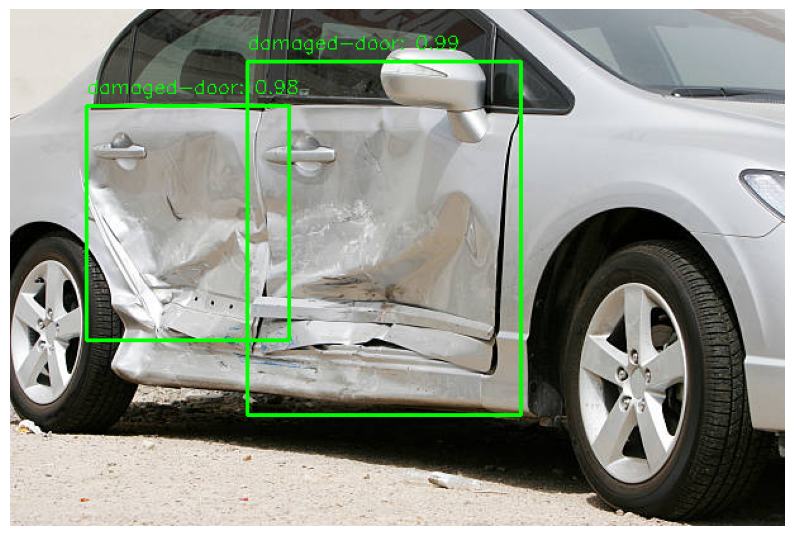

In [ ]:
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import cv2
from torchvision.models.detection import fasterrcnn_resnet50_fpn

class_names = [
    "Runningboard-Damage",
    "damage-front-windscreen",
    "damaged-door",
    "damaged-fender",
    "damaged-front-bumper",
    "damaged-head-light",
    "damaged-hood",
    "damaged-rear-bumper",
    "damaged-rear-window",
    "damaged-roof",
    "damaged-side-window",
    "damaged-tail-light",
    "damaged-trunk",
    "damaged-windscreen",
    "quaterpanel-dent",
]

# Load the trained model
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=17)  # Adjust num_classes
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Set the model to evaluation mode
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Define a function for inference
def run_inference(model, image_path, device, confidence_threshold=0.8):
    """
    Perform inference on a single image.
    Args:
        model: The trained Faster R-CNN model.
        image_path: Path to the input image.
        device: The device (CPU/GPU) to run inference.
        confidence_threshold: Minimum score to display bounding boxes.
    Returns:
        Annotated image with predictions.
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = F.to_tensor(image_rgb).unsqueeze(0).to(device)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        outputs = model(image_tensor)

    # Post-process the outputs
    outputs = outputs[0]
    pred_boxes = outputs["boxes"].cpu().numpy()  # Bounding boxes
    pred_labels = outputs["labels"].cpu().numpy()  # Labels
    pred_scores = outputs["scores"].cpu().numpy()  # Scores

    # Draw predictions on the image
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        if score > confidence_threshold:  # Apply the updated confidence threshold
            x_min, y_min, x_max, y_max = box.astype(int)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            class_name = class_names[label - 1] if label > 0 else "Background"
            text = f"{class_name}: {score:.2f}"
            cv2.putText(image, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return image

# Run inference on a test image
test_image_path = "/content/detectionTest1.jpg"
device = "cuda" if torch.cuda.is_available() else "cpu"
output_image = run_inference(model, test_image_path, device, confidence_threshold=0.8)

# Display the annotated image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.axis("off")
plt.show()



In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!cp -r '/content/training_results.csv' '/content/drive/MyDrive/DamageDetection/Faster-RCNN'